In [16]:
#%matplotlib inline
import pandas as pd
#import numpy as np
import seaborn as sns
#import matplotlib.pyplot as plt

**0.** Pomocí grafu porovnej vývoj ročního úhrnu srážek v jednotlivých stanicích.

In [1]:
def extract_and_clean_chmi_excel_sheet(excel_data, sheet_name):
    """Parse ČHMÚ historical meteo excel data"""
    # načti list z excel souboru a převeď na tidy data formát
    data_tidy = (
        excel_data.parse(sheet_name, skiprows=3)
        .melt(id_vars=["rok", "měsíc"], var_name="den", value_name=sheet_name)
        .dropna()
    )
    # vytvoř časovou řadu datumů
    datum = pd.to_datetime(
        data_tidy[["rok", "měsíc", "den"]].rename(
            columns={"rok": "year", "měsíc": "month", "den": "day"}
        )
    )
    # přidej sloupec datum jako index a odstraň den, měsíc, rok a vrať setříděný výsledek
    return (
        data_tidy.assign(datum=datum)
        .set_index("datum")
        .drop(columns=["rok", "měsíc", "den"])
        .sort_index()
    )

In [4]:
import os

tidy_all_list = []

mapping = {
    "B2BTUR01.xls": "brno",
    "C1KOCE01.xls": "kocelovice",
    "L2PRIM01.xls": "primda",
    "O1LYSA01.xls": "lysa",
    "O1MOSN01.xls": "mosnov",
    "P1PLIB01.xls": "libus",
    "P1PRUZ01.xls": "ruzyne",
    "P3KOSE01.xls": "kosetice",
    "P3PRIB01.xls": "pribyslav",
    "U1MILE01.xls": "milesovka",
    "U2LIBC01.xls": "liberec"
}

for file in os.listdir("eda3/eda-univariate-timeseries/"):
    if file.endswith(".xls") and file != "P1PRUZ01schibami.xls":
        excel_data = pd.ExcelFile(f"eda3/eda-univariate-timeseries/{file}")
        extracted_sheets = (
            extract_and_clean_chmi_excel_sheet(excel_data, sheet_name)
            for sheet_name in excel_data.sheet_names[1:]
            )
        data_tidy = pd.concat(extracted_sheets, axis=1)
        data_tidy["misto"] = mapping[file]
        tidy_all_list.append(data_tidy)
tidy_all = pd.concat(tidy_all_list)
tidy_all = tidy_all.sort_index()

In [5]:
tidy_all.columns

Index(['teplota průměrná', 'teplota maximální', 'teplota minimální',
       'rychlost větru ', 'tlak vzduchu', 'vlhkost vzduchu', 'úhrn srážek',
       'celková výška sněhu', 'sluneční svit', 'misto', 'rychlost větru'],
      dtype='object')

In [6]:
uhrn_srazek = tidy_all[["úhrn srážek", "misto"]].pivot_table(values='úhrn srážek', index='datum', columns='misto')
uhrn_srazek

misto,brno,kocelovice,kosetice,liberec,libus,lysa,milesovka,mosnov,pribyslav,primda,ruzyne
datum,,,,,,,,,,,
1961-01-01,2.3,NaN,0.0,0.1,NaN,3.8,1.3,1.8,0.9,0.4,0.0
1961-01-02,0.3,NaN,0.0,0.0,NaN,1.1,0.3,0.6,0.5,0.0,0.0
1961-01-03,0.0,NaN,0.3,0.0,NaN,0.9,0.9,0.0,0.7,2.9,0.0
1961-01-04,0.0,NaN,0.2,1.2,NaN,11.0,0.9,3.0,0.2,1.0,0.0
1961-01-05,0.0,NaN,0.4,0.3,NaN,1.2,0.6,0.0,0.6,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.0,0.0,0.3,3.4,0.2,25.1,2.7,2.8,0.2,0.0,NaN
2019-12-28,0.0,0.0,0.0,0.3,0.0,3.7,0.1,0.3,0.0,0.0,NaN
2019-12-29,0.0,0.0,0.0,0.0,0.0,1.4,0.0,0.0,0.0,0.0,NaN


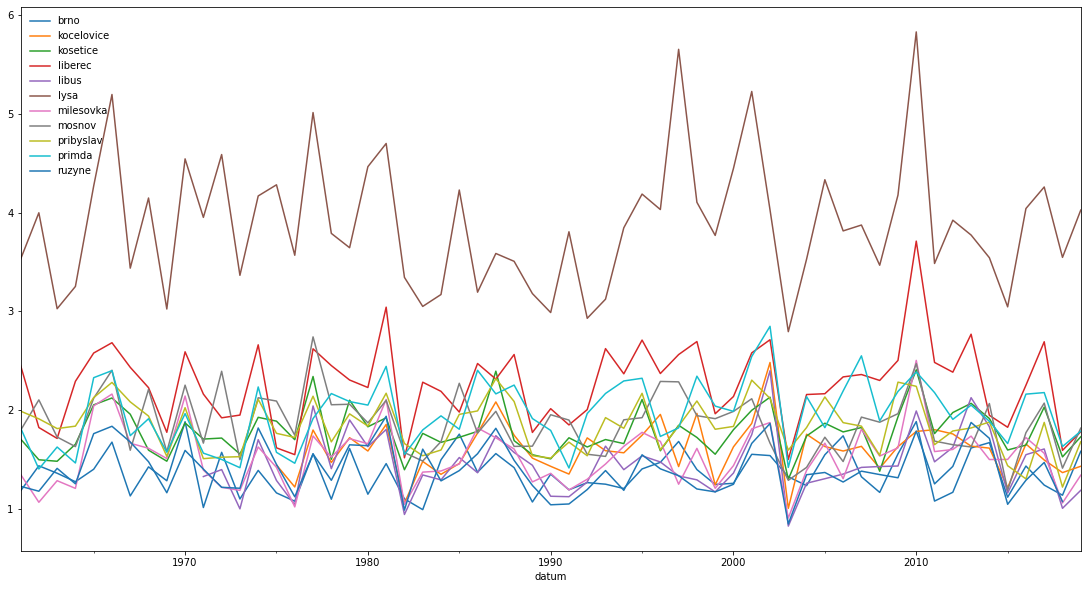

In [8]:
uhrn_srazek_plot = uhrn_srazek.resample("1Y").mean().plot(
    figsize = (19, 10),   
)
uhrn_srazek_plot.legend(
    loc='upper left',
    frameon=False)

**1.** Zjisti, ve které z těchto stanic byl nejteplejší den v roce 2010 a který to byl.

In [9]:
tidy_all.loc[tidy_all.index.year == 2010][["teplota průměrná", "misto"]].sort_values("teplota průměrná", ascending=False)

,teplota průměrná,misto
datum,,
2010-07-16,28.4,libus
2010-07-12,28.3,libus
2010-07-11,27.8,libus
2010-07-12,27.4,ruzyne
2010-07-16,27.3,ruzyne
...,...,...
2010-01-23,-14.7,mosnov
2010-01-27,-14.7,pribyslav
2010-12-26,-15.0,lysa


**2.** Zjisti, kde bylo (v průměru) nejteplejších 90 % dní v roce 2018 a kde nejstudenějších 10 %.

In [10]:
tidy_all.loc[tidy_all.index.year == 2018][["teplota průměrná", "misto"]].sort_values("teplota průměrná", ascending=False)

,teplota průměrná,misto
datum,,
2018-07-31,28.9,ruzyne
2018-08-01,28.9,libus
2018-07-31,28.7,libus
2018-08-01,28.6,ruzyne
2018-08-09,28.5,brno
...,...,...
2018-02-24,-15.5,lysa
2018-02-28,-18.1,lysa
2018-02-26,-18.6,lysa


**3.** Porovnej průměrný denní svit v 90. letech (1990 - 1999) v Praze a na Lysé Hoře.

In [11]:
slunecni_svit = tidy_all[["sluneční svit", "misto"]].pivot_table(values='sluneční svit', index='datum', columns='misto')
slunecni_svit

misto,brno,kocelovice,kosetice,liberec,libus,lysa,milesovka,mosnov,pribyslav,primda,ruzyne
datum,,,,,,,,,,,
1961-01-01,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,1.2,0.4
1961-01-02,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1961-01-03,0.2,NaN,NaN,0.0,NaN,0.0,0.0,4.9,0.0,0.0,0.0
1961-01-04,0.6,NaN,NaN,0.0,NaN,0.0,1.1,2.7,0.0,2.2,1.0
1961-01-05,1.0,NaN,NaN,0.0,NaN,0.0,0.8,2.8,0.0,0.0,2.2
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.4,NaN
2019-12-28,0.8,0.1,0.2,0.0,0.1,0.0,0.0,0.0,1.4,0.0,NaN
2019-12-29,0.0,5.2,0.6,4.7,4.4,0.0,6.8,0.0,0.1,6.7,NaN


In [12]:
slunecni_svit_devadesatky = slunecni_svit.loc[pd.Timestamp(1990, 1, 1) : pd.Timestamp(1999, 12, 31)]
slunecni_svit_devadesatky

misto,brno,kocelovice,kosetice,liberec,libus,lysa,milesovka,mosnov,pribyslav,primda,ruzyne
datum,,,,,,,,,,,
1990-01-01,0.0,0.0,0.0,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0
1990-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-01-03,1.2,0.0,0.0,0.7,0.0,0.0,0.0,0.0,0.7,0.0,0.0
1990-01-04,5.4,4.0,6.5,3.0,5.8,8.2,1.8,5.4,5.7,0.0,5.9
1990-01-05,0.0,0.0,0.0,0.0,0.0,7.9,0.0,6.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1999-12-27,0.5,0.9,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.4
1999-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-12-29,0.7,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
slunecni_svit_devadesatky_rocne = slunecni_svit_devadesatky.resample("1Y").mean()
slunecni_svit_devadesatky_rocne[["libus", "lysa"]]

misto,libus,lysa
datum,,
1990-12-31,5.080822,4.351781
1991-12-31,4.564658,4.037808
1992-12-31,4.885792,4.540437
1993-12-31,4.992877,4.416712
1994-12-31,4.872877,4.281644
1995-12-31,4.430137,4.039452
1996-12-31,4.173770,4.156831
1997-12-31,5.109589,4.250685
1998-12-31,4.813151,4.095616


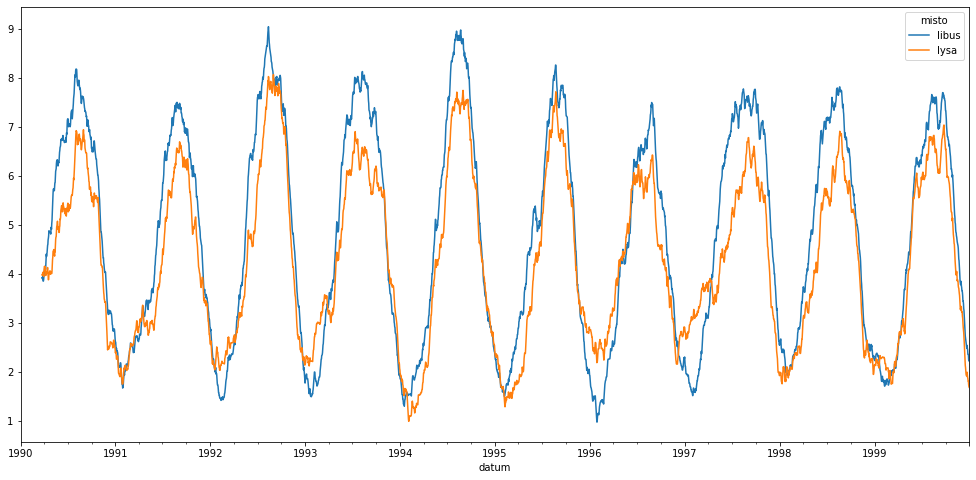

In [14]:
slunecni_svit_devadesatky[["libus", "lysa"]].rolling("93D", min_periods=84).mean().plot(
    figsize = (17, 8)
);

Text(0.5, 1.0, 'Sluneční svit v devadesátých letech')

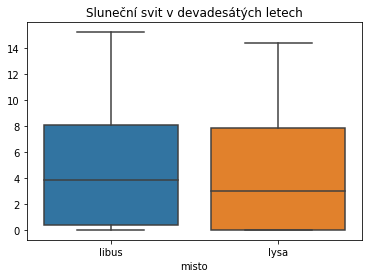

In [17]:
import seaborn as sns
plt3 = sns.boxplot(
    data=slunecni_svit_devadesatky[["libus", "lysa"]]
)
plt3.set_title('Sluneční svit v devadesátých letech')

**4.** Načti data z https://data4pydata.s3-eu-west-1.amazonaws.com/pyladies/P1PRUZ01schibami.xls, kde jsou chybějící data označena jako #CHYBA MĚŘENÍ.
<br>
<br>
Pomocí volby na_values při načítání dat z Excel souboru správně označ chyby měření jako chybějící data.
Odstraň pouze řádky, kde je špatné datum (tip: použij dropna(subset=)). Pomocí fillna pak nahraď chybějící měření poslední předchozí hodnotou.

In [18]:
def extract_and_clean_chmi_excel_sheet_chyba(excel_data, sheet_name):
    """Parse ČHMÚ historical meteo excel data"""
    # načti list z excel souboru a převeď na tidy data formát
    data_tidy = (
        excel_data.parse(sheet_name, skiprows=3, na_values="#CHYBA MĚŘENÍ")
        .melt(id_vars=["rok", "měsíc"], var_name="den", value_name=sheet_name)
        .dropna()
    )
    # vytvoř časovou řadu datumů
    datum = pd.to_datetime(
        data_tidy[["rok", "měsíc", "den"]].rename(
            columns={"rok": "year", "měsíc": "month", "den": "day"}
        )
    )
    # přidej sloupec datum jako index a odstraň den, měsíc, rok a vrať setříděný výsledek
    return (
        data_tidy.assign(datum=datum)
        .set_index("datum")
        .drop(columns=["rok", "měsíc", "den"])
        .sort_index()
    )

In [19]:
# otevři Excel soubor
excel_data_ruzyne_chiby = pd.ExcelFile("eda3/eda-univariate-timeseries/P1PRUZ01schibami.xls")
# načti všechny listy kromě prvního
extracted_sheets = (
    extract_and_clean_chmi_excel_sheet_chyba(excel_data_ruzyne_chiby, sheet_name)
    for sheet_name in excel_data_ruzyne_chiby.sheet_names[1:]
)
# spoj všechny listy do jednoho DataFrame
ruzyne_chiby = pd.concat(extracted_sheets, axis=1)
ruzyne_chiby

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit
datum,,,,,,,,,
1961-01-01,-2.0,1.0,-3.4,1.7,969.9,87.0,0.0,6.0,0.4
1961-01-02,-1.9,-1.2,-2.4,3.0,965.2,89.0,0.0,4.0,0.0
1961-01-03,0.1,1.0,-2.6,2.7,952.3,80.0,0.0,3.0,0.0
1961-01-04,-0.3,2.1,-2.0,3.3,953.6,87.0,0.0,3.0,1.0
1961-01-05,0.4,2.8,-4.3,6.3,963.9,81.0,0.0,2.0,2.2
...,...,...,...,...,...,...,...,...,...
2018-12-27,4.0,6.5,2.7,5.4,981.4,88.0,0.0,0.0,0.5
2018-12-28,3.9,6.2,0.3,3.9,981.5,82.0,0.0,0.0,3.9
2018-12-29,2.2,4.8,1.3,5.8,983.8,87.0,0.8,0.0,0.5


In [20]:
ruzyne_chiby[(ruzyne_chiby["teplota průměrná"] == "#CHYBA MĚŘENÍ") | (ruzyne_chiby["úhrn srážek"] == "#CHYBA MĚŘENÍ") | (ruzyne_chiby["rychlost větru"] == "#CHYBA MĚŘENÍ")]

c:\users\lam\pydata\venv\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
c:\users\lam\pydata\venv\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)
c:\users\lam\pydata\venv\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit
datum,,,,,,,,,


**5.** Jak často přijíždí Svatý Martin na bílém koni? Jaké je procento svátků Sv. Martina (11. 11.), kdy byla celková výška sněhu větší než 0?

In [21]:
tidy_all.head()

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit,misto,rychlost větru
datum,,,,,,,,,,,
1961-01-01,-0.8,0.5,-2.5,0.7,988.4,96.0,2.3,5.0,0.0,brno,NaN
1961-01-01,-1.3,1.6,-3.1,NaN,986.7,94.0,1.8,0.0,0.0,mosnov,3.3
1961-01-01,-3.7,-1.3,-5.0,NaN,914.7,96.0,1.3,24.0,0.0,milesovka,4.7
1961-01-01,-2.0,1.0,-3.4,NaN,969.9,87.0,0.0,6.0,0.4,ruzyne,1.7
1961-01-01,-6.1,-4.9,-7.0,NaN,861.6,96.0,3.8,13.0,0.0,lysa,7.0


In [22]:
martin = tidy_all.loc[
    (tidy_all.index.month == 11)
    & (tidy_all.index.day == 11),
]
martin.head()

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit,misto,rychlost větru
datum,,,,,,,,,,,
1961-11-11,6.1,10.3,4.2,NaN,975.1,96.0,0.0,0.0,0.1,mosnov,0.3
1961-11-11,2.2,3.1,1.2,NaN,906.3,100.0,1.0,0.0,0.0,milesovka,5.0
1961-11-11,6.7,8.4,4.4,1.7,976.0,89.0,0.0,0.0,0.0,brno,NaN
1961-11-11,5.1,5.9,3.6,NaN,957.7,95.0,0.9,0.0,0.0,liberec,0.3
1961-11-11,4.7,8.7,2.6,NaN,941.9,95.0,0.0,0.0,0.0,pribyslav,3.3


In [23]:
snih_martin = martin[["celková výška sněhu", "misto"]]
snih_martin.head()

,celková výška sněhu,misto
datum,,
1961-11-11,0.0,mosnov
1961-11-11,0.0,milesovka
1961-11-11,0.0,brno
1961-11-11,0.0,liberec
1961-11-11,0.0,pribyslav


In [24]:
snihnamartina = snih_martin[snih_martin["celková výška sněhu"] > 0]
snihnamartina

,celková výška sněhu,misto
datum,,
1962-11-11,4.0,lysa
1965-11-11,3.0,primda
1965-11-11,3.0,lysa
1970-11-11,2.0,milesovka
1970-11-11,10.0,lysa
...,...,...
2016-11-11,7.0,milesovka
2016-11-11,5.0,primda
2016-11-11,1.0,liberec


In [25]:
snihnamartina["misto"].value_counts()

lysa          25
milesovka      9
primda         9
liberec        5
ruzyne         4
pribyslav      4
kocelovice     3
kosetice       3
libus          1
mosnov         1
Name: misto, dtype: int64

**6.** Který z ledových mužů je nejmrazivější? Pankrác (12. 5.), Servác (13. 5.) nebo Bonifác (14. 5.)? Zjisti to porovnáním procent těchto dní s minimální teplotou < 0. Pokud budou procenta vyrovnaná, vyhraje den s nižší průměrnou teplotou.



In [26]:
pankrac = tidy_all.loc[
    (tidy_all.index.month == 5)
    & (tidy_all.index.day == 12),
]
pankrac.head()

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit,misto,rychlost větru
datum,,,,,,,,,,,
1961-05-12,2.3,4.0,1.1,NaN,920.7,97.0,2.7,0.0,1.0,milesovka,7.0
1961-05-12,8.7,13.5,6.5,5.7,989.4,69.0,4.4,0.0,6.1,brno,NaN
1961-05-12,6.8,11.0,4.9,NaN,987.6,85.0,0.1,0.0,5.7,mosnov,3.3
1961-05-12,5.4,8.4,4.4,NaN,972.0,94.0,5.5,0.0,1.7,liberec,2.0
1961-05-12,3.0,4.5,1.9,NaN,NaN,97.0,4.7,0.0,0.0,primda,3.3


In [27]:
servac = tidy_all.loc[
    (tidy_all.index.month == 5)
    & (tidy_all.index.day == 13),
]
servac.head()

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit,misto,rychlost větru
datum,,,,,,,,,,,
1961-05-13,0.9,4.1,-1.7,NaN,864.6,98.0,1.9,12.0,3.4,lysa,5.7
1961-05-13,6.9,10.2,3.1,NaN,967.5,87.0,2.2,0.0,1.4,liberec,1.3
1961-05-13,10.2,16.0,1.0,NaN,970.4,81.0,1.0,0.0,3.4,ruzyne,2.7
1961-05-13,9.4,14.2,5.2,NaN,985.3,78.0,1.6,0.0,7.3,mosnov,3.7
1961-05-13,7.3,9.6,3.1,NaN,953.0,89.0,5.7,0.0,2.3,pribyslav,1.3


In [28]:
bonifac = tidy_all.loc[
    (tidy_all.index.month == 5)
    & (tidy_all.index.day == 14),
]
bonifac.head()

,teplota průměrná,teplota maximální,teplota minimální,rychlost větru,tlak vzduchu,vlhkost vzduchu,úhrn srážek,celková výška sněhu,sluneční svit,misto,rychlost větru
datum,,,,,,,,,,,
1961-05-14,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,kosetice,NaN
1961-05-14,5.4,10.1,3.3,NaN,965.2,72.0,0.2,0.0,8.3,liberec,3.7
1961-05-14,7.9,11.8,5.4,NaN,NaN,75.0,0.0,0.0,8.0,primda,5.0
1961-05-14,4.4,9.0,2.6,NaN,914.2,79.0,0.0,0.0,12.0,milesovka,9.0
1961-05-14,10.3,17.6,6.2,2.7,983.2,77.0,0.0,0.0,6.8,brno,NaN


In [29]:
pankrac_teplota_min = pankrac[pankrac["teplota minimální"] < 0]
servac_teplota_min = servac[servac["teplota minimální"] < 0]
bonifac_teplota_min = bonifac[bonifac["teplota minimální"] < 0]

In [30]:
pankrac_teplota_min["teplota minimální"].count()

19

In [31]:
servac_teplota_min["teplota minimální"].count()

15

In [32]:
bonifac_teplota_min["teplota minimální"].count()

17

In [33]:
(pankrac_teplota_min["teplota minimální"].count()) > (servac_teplota_min["teplota minimální"].count()) < (bonifac_teplota_min["teplota minimální"].count())

True

In [34]:
(pankrac_teplota_min["teplota minimální"].count()) / (pankrac["teplota minimální"].count()) * 100

3.1825795644891124

In [35]:
(servac_teplota_min["teplota minimální"].count()) / (servac["teplota minimální"].count()) * 100

2.512562814070352

In [36]:
(bonifac_teplota_min["teplota minimální"].count()) / (bonifac["teplota minimální"].count()) * 100

2.8475711892797317